In [27]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from statsmodels.graphics.tsaplots import plot_acf


In [28]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt

In [29]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.23.5
5.7.2
0.15.1


## データの準備など

In [30]:
# 各項目のデータの準備

# カテゴリ×カテゴリ
cc_parray = pd.read_csv(f"../data/3-10-1-interaction-1.csv")
cc_df = pd.DataFrame(cc_parray)
print(cc_df.shape)
display(cc_df.head())

# カテゴリ×数量
cn_parray = pd.read_csv(f"../data/3-10-2-interaction-2.csv")
cn_df = pd.DataFrame(cn_parray)
print(cn_df.shape)
display(cn_df.head())

# 数量×数量
nn_parray = pd.read_csv(f"../data/3-10-3-interaction-3.csv")
nn_df = pd.DataFrame(nn_parray)
print(nn_df.shape)
display(nn_df.head())

(100, 3)


,sales,publicity,bargen
0,87.5,not,not
1,103.7,not,not
2,83.3,not,not
3,131.9,not,not
4,106.6,not,not


(100, 3)


,sales,publicity,temperature
0,74.0,not,8.0
1,60.2,not,11.2
2,91.2,not,17.2
3,81.8,not,27.2
4,90.9,not,6.1


(100, 3)


,sales,product,clerk
0,142.5,17,3
1,193.2,38,4
2,376.7,33,9
3,231.0,17,8
4,134.8,48,3


## カテゴリ×カテゴリ

### 可視化

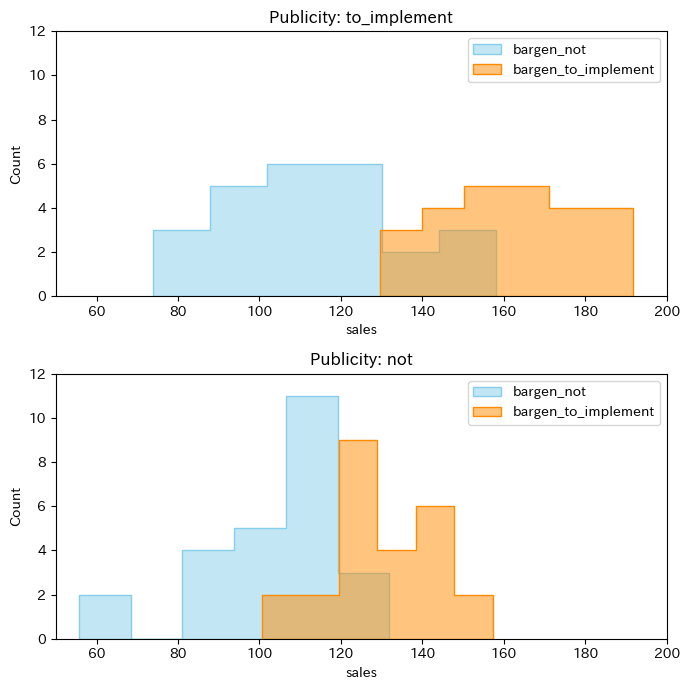

In [54]:
# ヒストグラムで分布可視化
pub_imp_df = cc_df[cc_df["publicity"]=="to_implement"]
pub_not_df = cc_df[cc_df["publicity"]=="not"]

fig, axes = plt.subplots(2, 1, figsize=(7, 7))
sns.histplot(pub_imp_df[pub_imp_df["bargen"]=="not"]["sales"], 
                  ax=axes[0], color="skyblue", alpha=0.5, element="step",
                  label="bargen_not")
sns.histplot(pub_imp_df[pub_imp_df["bargen"]=="to_implement"]["sales"], 
                  ax=axes[0], color="darkorange", alpha=0.5, element="step", 
                  label="bargen_to_implement")

sns.histplot(pub_not_df[pub_not_df["bargen"]=="not"]["sales"], 
                  ax=axes[1], color="skyblue", alpha=0.5, element="step",
                  label="bargen_not")
sns.histplot(pub_not_df[pub_not_df["bargen"]=="to_implement"]["sales"], 
                  ax=axes[1], color="darkorange", alpha=0.5, element="step", 
                  label="bargen_to_implement")

# 軸の設定
for ax in axes:
    ax.set_xlim(50, 200)
    ax.set_ylim(0, 12)
    ax.legend()

# 各axesにタイトル
axes[0].set_title("Publicity: to_implement")
axes[1].set_title("Publicity: not")

plt.tight_layout()
plt.show()

In [69]:
# データの準備
y = cc_parray["sales"].values
X_df = pd.get_dummies(cc_parray.drop("sales",axis=1), dtype=int, drop_first=True)
X_df = X_df.rename(columns = {"publicity_to_implement":"publicity", 
                    "bargen_to_implement":"bargen"})
X_df["pub_bagen"] = X_df["publicity"] * X_df["bargen"]
col_li = X_df.columns
X = X_df.values

print(y.shape)
print(y[:10])
print(X.shape)
print(X[:10])
print(col_li)

(100,)
[ 87.5 103.7  83.3 131.9 106.6  83.6 109.7 114.8 111.5  93.9]
(100, 3)
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
Index(['publicity', 'bargen', 'pub_bagen'], dtype='object')


### ベイズ推論

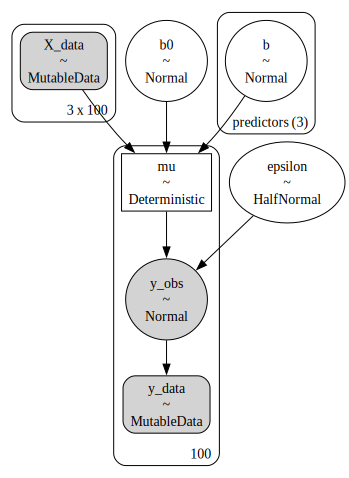

In [70]:
# 確率モデルの定義
model = pm.Model(coords={"predictors":col_li})

with model:
    # 観測値をDataとして定義
    X_data = pm.Data("X_data", X.T, mutable=True)
    y_data = pm.Data("y_data", y, mutable=True)

    # パラメータの事前分布を定義
    b0 = pm.Normal("b0", mu=0, sigma=10000)
    b = pm.Normal("b", mu=0, sigma=10000, dims="predictors") # 仮説は無いので一括で同様に設定

    # 目的変数の期待値を確率変数として定義
    mu = pm.Deterministic("mu", b @ X_data + b0)

    # 誤差を確率変数として定義
    epsilon = pm.HalfNormal("epsilon", sigma=10000)

    # 観測値を持つ確率変数として定義
    y_obs = pm.Normal("y_obs", mu=mu, sigma=epsilon, observed=y_data)

g = pm.model_to_graphviz(model)
display(g)

In [71]:
# パラメータのMCMCサンプリング
with model:
    idata1 = pm.sample(
        chains = 2,
        tune = 1000,
        draws = 1000,
        random_seed = 42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b0, b, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


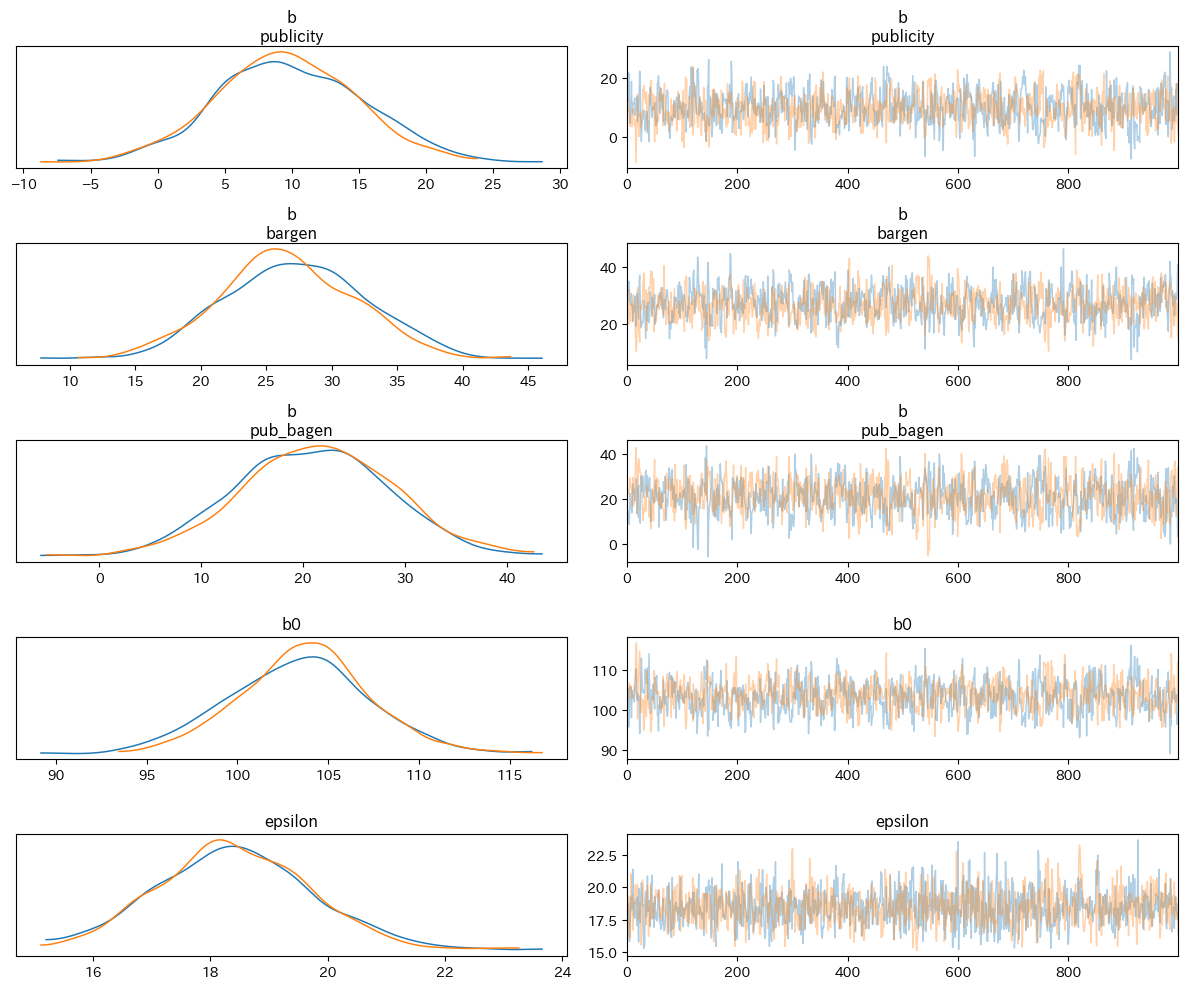

In [72]:
# 事後分布の可視化
az.plot_trace(idata1, compact=False, var_names=["b", "b0", "epsilon"])
plt.tight_layout();

In [74]:
# MCMCサンプルの統計量
az.summary(idata1, var_names=["b", "b0", "epsilon"])

# b[pub_bagen]が正であることから、相乗効果が見込まれる

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[publicity],9.715,5.299,-0.196,19.853,0.189,0.136,789.0,961.0,1.00
b[bargen],26.944,5.382,17.133,37.182,0.204,0.144,695.0,1081.0,1.01
b[pub_bagen],21.128,7.482,7.490,35.241,0.272,0.192,758.0,1062.0,1.00
b0,103.543,3.706,96.093,110.224,0.132,0.093,793.0,839.0,1.00
epsilon,18.434,1.330,15.832,20.791,0.037,0.026,1309.0,1337.0,1.00


## カテゴリ×数量

### 可視化

<Axes: xlabel='temperature', ylabel='sales'>

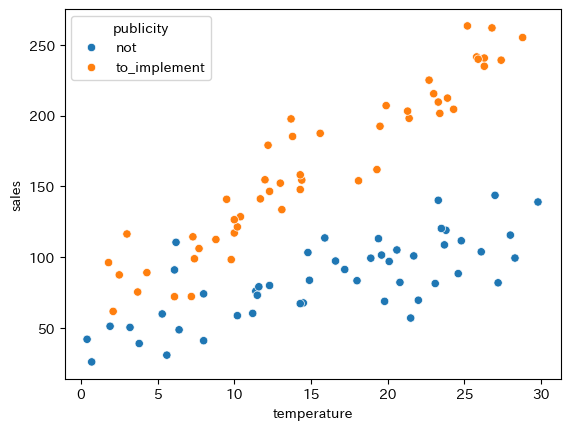

In [80]:
fig, ax = plt.subplots()

sns.scatterplot(x=cn_parray["temperature"], y=cn_parray["sales"], 
                hue=cn_parray["publicity"])

In [84]:
# データの準備
y = cn_parray["sales"].values
X_df = pd.get_dummies(cn_parray.drop(["sales", "temperature"], axis=1), dtype=int, drop_first=True)
X_df = X_df.rename(columns = {"publicity_to_implement":"publicity"})  
X_df["temperature"] = cn_df["temperature"]           
X_df["pub_tmptr"] = X_df["publicity"] * X_df["temperature"]
col_li = X_df.columns
X = X_df.values

print(y.shape)
print(y[:10])
print(X.shape)
print(X[:10])
print(col_li)

(100,)
[ 74.   60.2  91.2  81.8  90.9 143.6  99.3  68.7  99.2  51.1]
(100, 3)
[[ 0.   8.   0. ]
 [ 0.  11.2  0. ]
 [ 0.  17.2  0. ]
 [ 0.  27.2  0. ]
 [ 0.   6.1  0. ]
 [ 0.  27.   0. ]
 [ 0.  28.3  0. ]
 [ 0.  19.8  0. ]
 [ 0.  18.9  0. ]
 [ 0.   1.9  0. ]]
Index(['publicity', 'temperature', 'pub_tmptr'], dtype='object')


### ベイズ推論

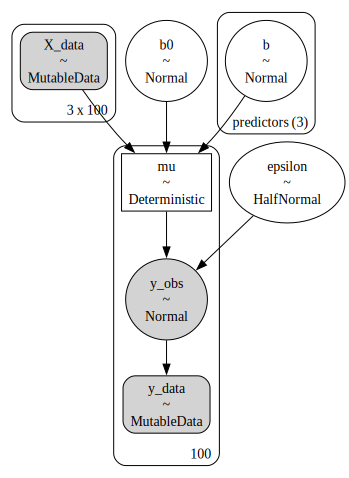

In [85]:
# 確率モデルの定義
model = pm.Model(coords={"predictors":col_li})

with model:
    # 観測値をDataとして定義
    X_data = pm.Data("X_data", X.T, mutable=True)
    y_data = pm.Data("y_data", y, mutable=True)

    # パラメータの事前分布を定義
    b0 = pm.Normal("b0", mu=0, sigma=10000)
    b = pm.Normal("b", mu=0, sigma=10000, dims="predictors") # 仮説は無いので一括で同様に設定

    # 目的変数の期待値を確率変数として定義
    mu = pm.Deterministic("mu", b @ X_data + b0)

    # 誤差を確率変数として定義
    epsilon = pm.HalfNormal("epsilon", sigma=10000)

    # 観測値を持つ確率変数として定義
    y_obs = pm.Normal("y_obs", mu=mu, sigma=epsilon, observed=y_data)

g = pm.model_to_graphviz(model)
display(g)

In [86]:
# パラメータのMCMCサンプリング
with model:
    idata1 = pm.sample(
        chains = 2,
        tune = 1000,
        draws = 1000,
        random_seed = 42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b0, b, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 34 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


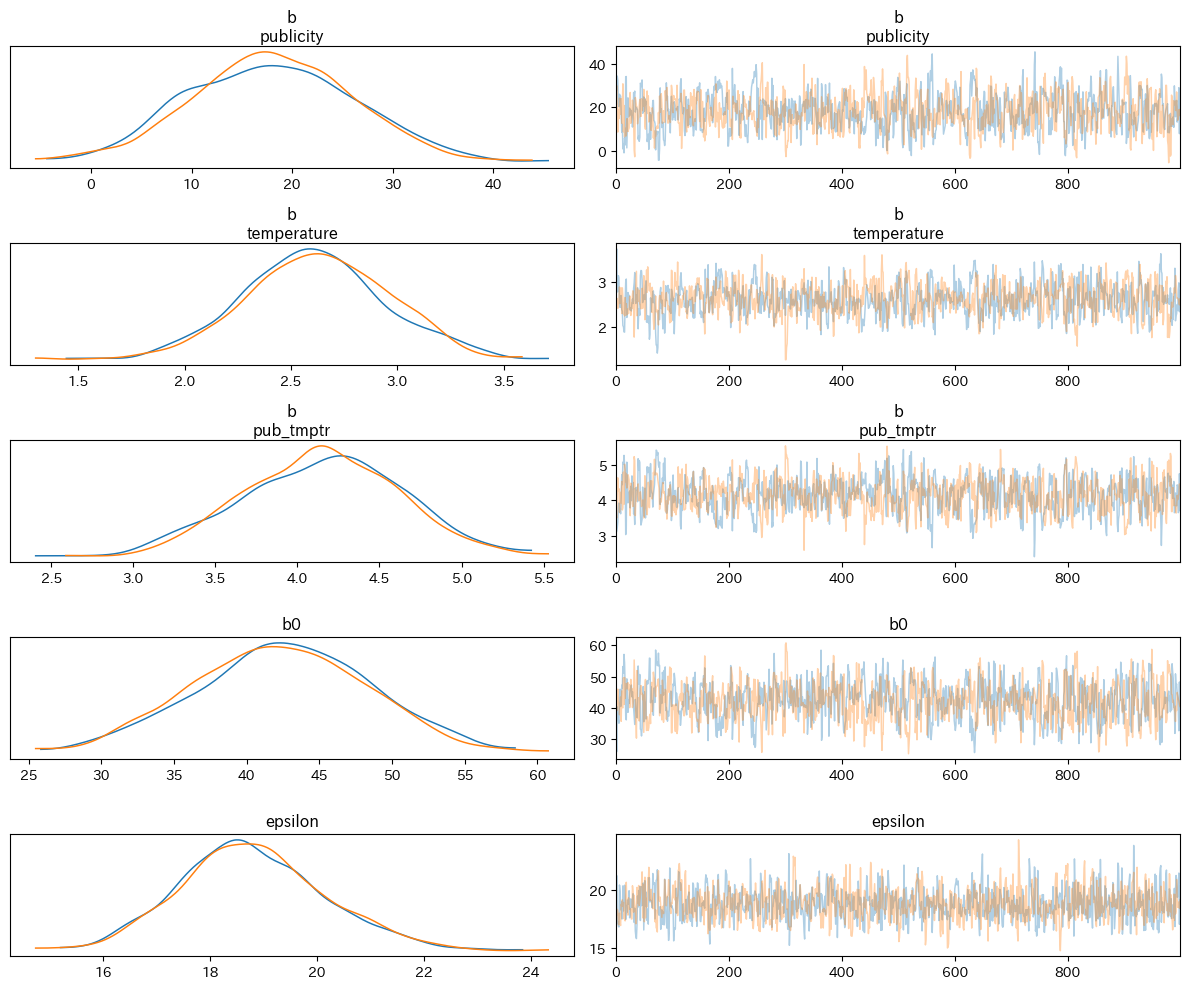

In [87]:
# 事後分布の可視化
az.plot_trace(idata1, compact=False, var_names=["b", "b0", "epsilon"])
plt.tight_layout();

In [88]:
# MCMCサンプルの統計量
az.summary(idata1, var_names=["b", "b0", "epsilon"])

# 宣伝自体の効果は18。気温の効果は宣伝無しでは2.6(主効果)、宣伝有りでは6.8(主効果+交互作用)。

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[publicity],18.043,8.185,4.302,34.412,0.318,0.227,663.0,769.0,1.00
b[temperature],2.616,0.334,2.005,3.245,0.012,0.009,745.0,955.0,1.00
b[pub_tmptr],4.151,0.474,3.184,4.947,0.019,0.013,654.0,717.0,1.01
b0,42.396,6.001,31.374,53.579,0.221,0.156,734.0,924.0,1.00
epsilon,18.799,1.347,16.390,21.385,0.039,0.028,1197.0,1169.0,1.00


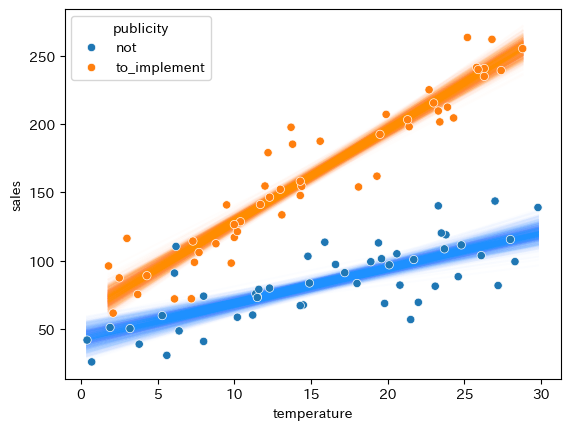

In [91]:
# 各天気における温度のデータを取得
pub_t = cn_df[cn_df["publicity"]=="to_implement"]["temperature"]
no_pub_t = cn_df[cn_df["publicity"]=="not"]["temperature"]

# サンプリング結果から釣獲尾数の期待値を取得
y_preds = idata1["posterior"]["mu"][0].values

# y_predsから各天気の値に対応するインデックスを取得
pub_index = cn_df[cn_df["publicity"]=="to_implement"].index.tolist()
no_pub_index = cn_df[cn_df["publicity"]=="not"].index.tolist()

# 晴れのポアソン回帰曲線
for i in range(y_preds.shape[0]):
    sunny_y_preds = y_preds[i][pub_index]
    sns.lineplot(x=pub_t, y=sunny_y_preds, color="darkorange", alpha=0.01, zorder=1)

# 曇りのポアソン回帰曲線
for i in range(y_preds.shape[0]):
    cloudy_y_preds = y_preds[i][no_pub_index]
    sns.lineplot(x=no_pub_t, y=cloudy_y_preds, color="dodgerblue", alpha=0.01, zorder=1)

# 観測データの散布図
ax = sns.scatterplot(x = cn_parray["temperature"], y = cn_parray["sales"],
                     hue = cn_parray["publicity"], zorder=2)

## 数量×数量

### 可視化

<Axes: xlabel='product', ylabel='sales'>

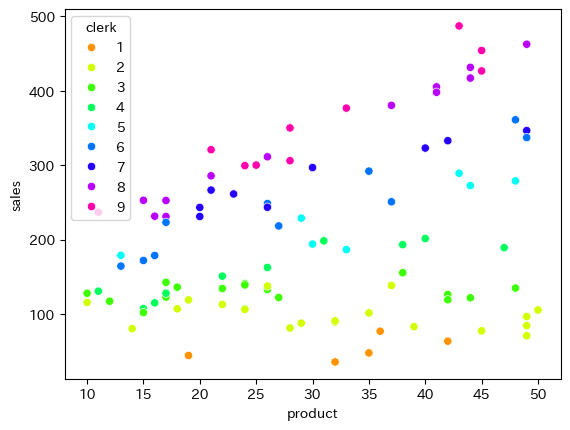

In [107]:
fig, ax = plt.subplots()
# カラーパレットを指定
palette = sns.color_palette("hsv", 9)  # 9種類の色を含むパレットを選択

sns.scatterplot(x=nn_parray["product"], y=nn_parray["sales"], 
                hue=nn_parray["clerk"], palette=palette)

In [110]:
nn_parray

,sales,product,clerk
0,142.5,17,3
1,193.2,38,4
2,376.7,33,9
3,231.0,17,8
4,134.8,48,3
...,...,...,...
95,136.0,18,3
96,122.1,27,3
97,80.2,14,2
98,101.9,15,3


In [111]:
# データの準備
y = nn_parray["sales"].values  
X_df = nn_df.drop("sales", axis=1)        
X_df["prdt_clk"] = X_df["product"] * X_df["clerk"]
col_li = X_df.columns
X = X_df.values

print(y.shape)
print(y[:10])
print(X.shape)
print(X[:10])
print(col_li)

(100,)
[142.5 193.2 376.7 231.  134.8 361.  252.8 289.2  87.6  89. ]
(100, 3)
[[ 17   3  51]
 [ 38   4 152]
 [ 33   9 297]
 [ 17   8 136]
 [ 48   3 144]
 [ 48   6 288]
 [ 15   8 120]
 [ 43   5 215]
 [ 29   2  58]
 [ 32   2  64]]
Index(['product', 'clerk', 'prdt_clk'], dtype='object')


### ベイズ推論

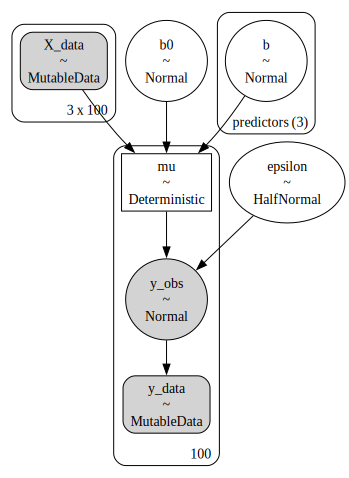

In [112]:
# 確率モデルの定義
model = pm.Model(coords={"predictors":col_li})

with model:
    # 観測値をDataとして定義
    X_data = pm.Data("X_data", X.T, mutable=True)
    y_data = pm.Data("y_data", y, mutable=True)

    # パラメータの事前分布を定義
    b0 = pm.Normal("b0", mu=0, sigma=10000)
    b = pm.Normal("b", mu=0, sigma=10000, dims="predictors") # 仮説は無いので一括で同様に設定

    # 目的変数の期待値を確率変数として定義
    mu = pm.Deterministic("mu", b @ X_data + b0)

    # 誤差を確率変数として定義
    epsilon = pm.HalfNormal("epsilon", sigma=10000)

    # 観測値を持つ確率変数として定義
    y_obs = pm.Normal("y_obs", mu=mu, sigma=epsilon, observed=y_data)

g = pm.model_to_graphviz(model)
display(g)

In [113]:
# パラメータのMCMCサンプリング
with model:
    idata1 = pm.sample(
        chains = 2,
        tune = 1000,
        draws = 1000,
        random_seed = 42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b0, b, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 119 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


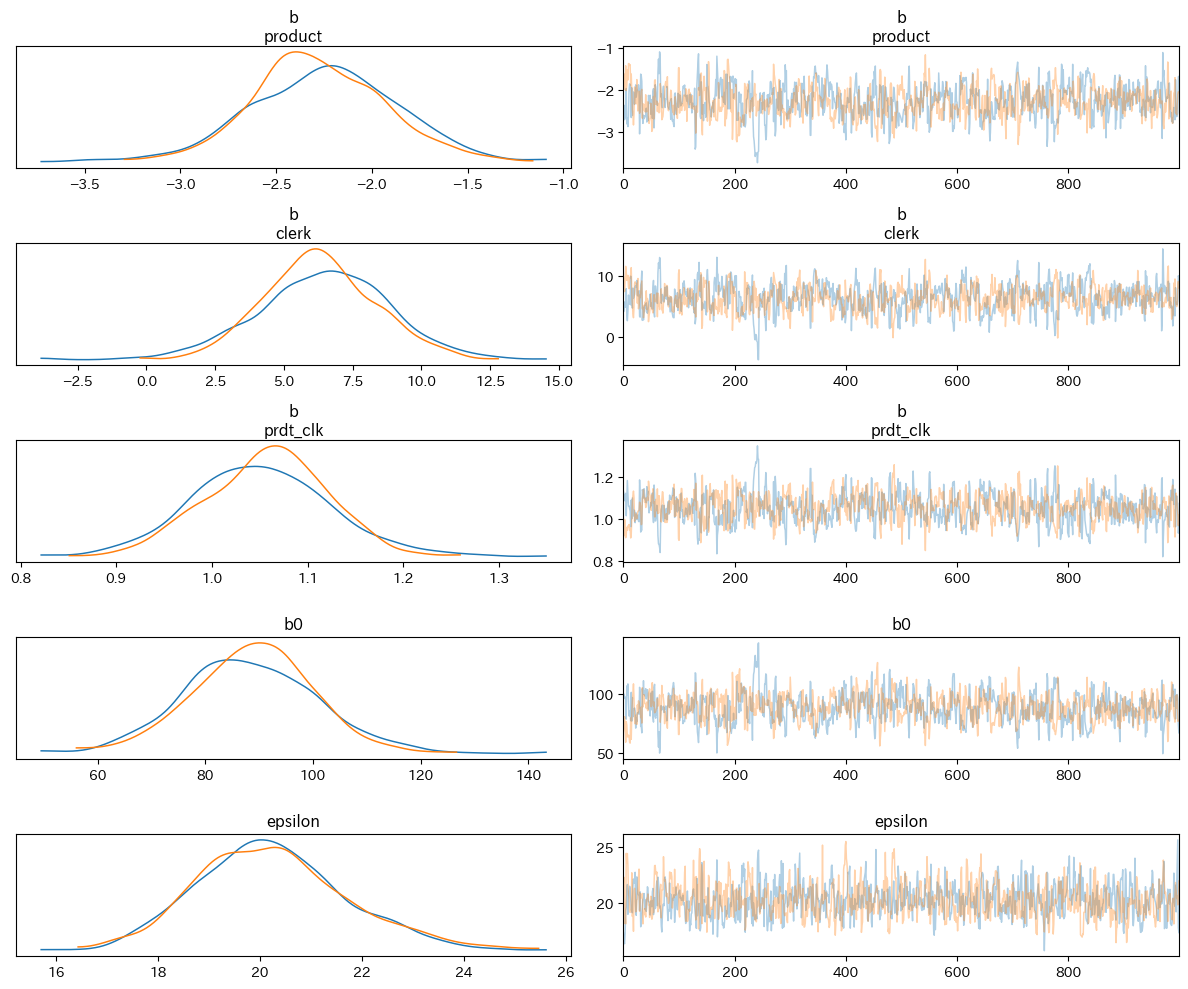

In [114]:
# 事後分布の可視化
az.plot_trace(idata1, compact=False, var_names=["b", "b0", "epsilon"])
plt.tight_layout();

In [115]:
# MCMCサンプルの統計量
az.summary(idata1, var_names=["b", "b0", "epsilon"])

# 店員数が少ないと、製品数を増やすと売り上げが減る

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[product],-2.264,0.371,-2.923,-1.546,0.017,0.012,509.0,731.0,1.00
b[clerk],6.372,2.197,2.349,10.564,0.100,0.071,491.0,829.0,1.01
b[prdt_clk],1.054,0.068,0.928,1.182,0.003,0.002,513.0,801.0,1.01
b0,88.522,11.968,65.178,110.354,0.552,0.396,478.0,687.0,1.01
epsilon,20.243,1.470,17.674,23.224,0.052,0.037,803.0,898.0,1.00


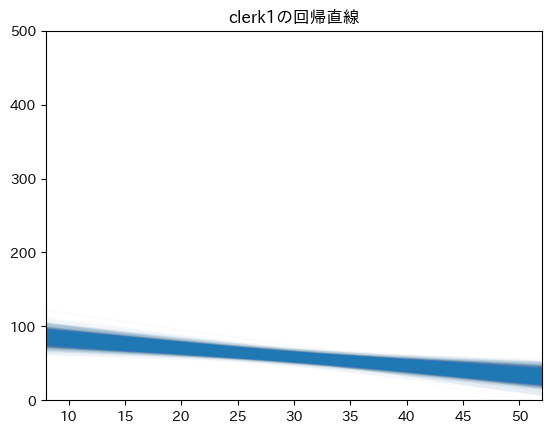

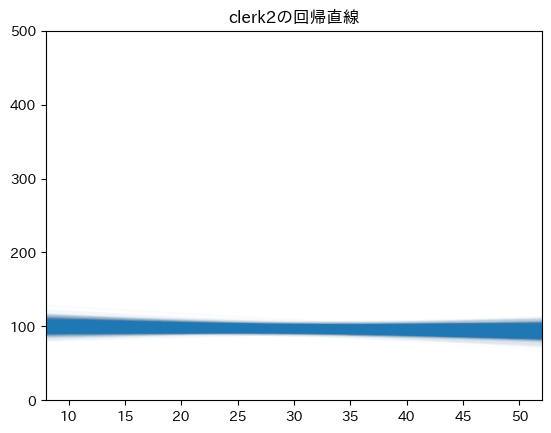

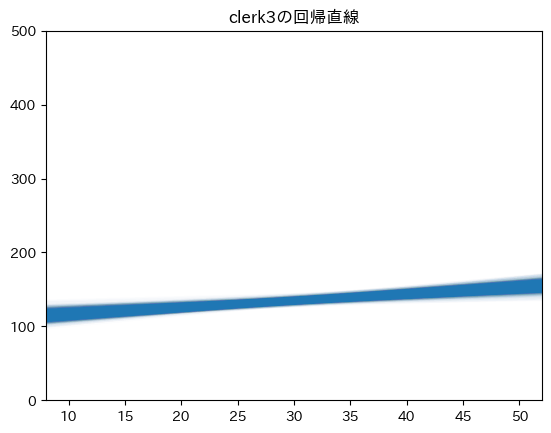

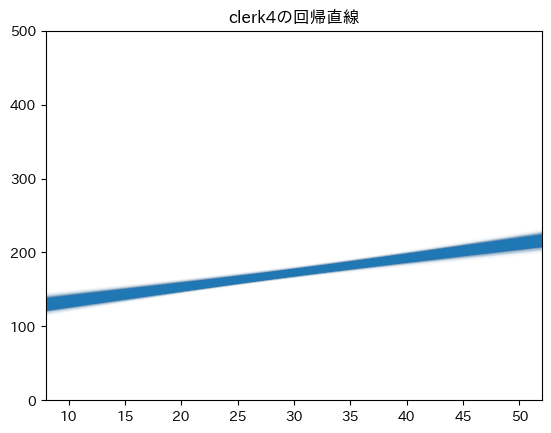

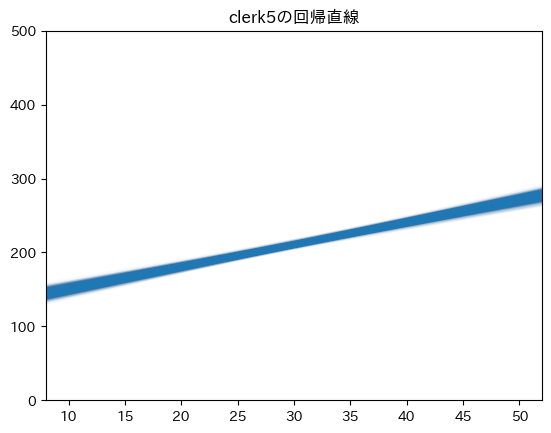

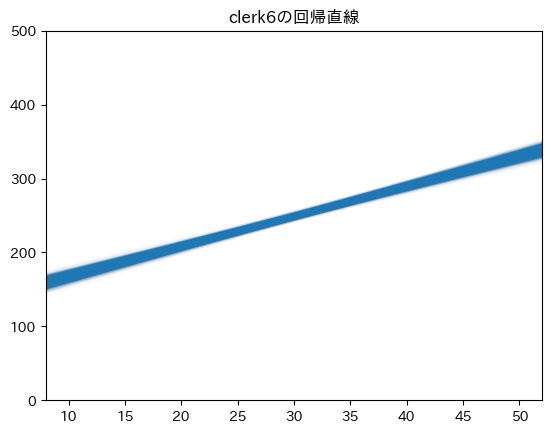

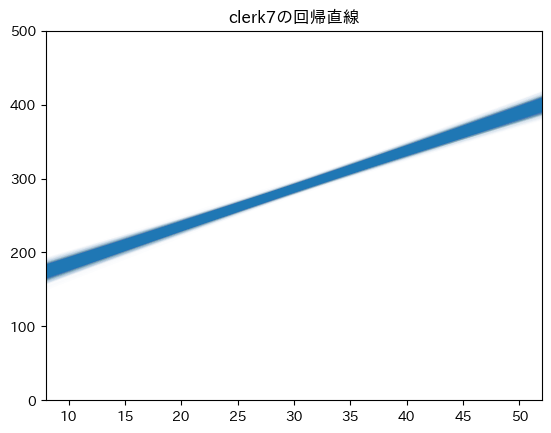

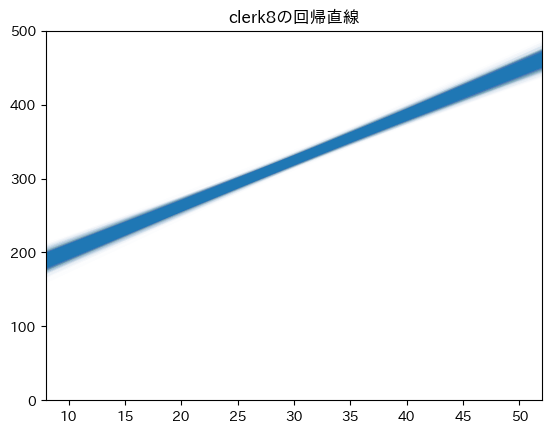

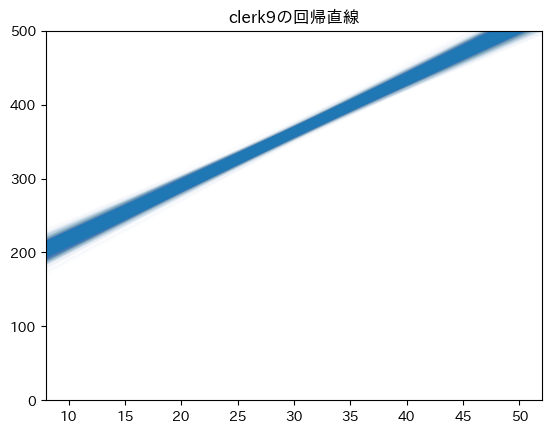

In [126]:
# サンプリング結果からパラメータ抽出
b_ifr = idata1["posterior"]["b"].values.reshape(-1, 3)
b0_ifr = idata1["posterior"]["b0"].values.reshape(-1, 1)

prd_min = nn_parray["product"].min()
prd_max = nn_parray["product"].max()

for i in range(1, 10):
    parray = nn_parray[nn_parray["clerk"]==i]
    x_data = np.array([[prd_min, prd_max], [i, i], [i*prd_min, i*prd_max]])
    y_preds = b_ifr @ x_data + b0_ifr

    fig, ax = plt.subplots()
    for y_pred in y_preds:
        ax.axline((prd_min, y_pred[0]), (prd_max, y_pred[1]), alpha=0.01)
    ax.set(ylim=(0, 500))
    ax.set_title(f"clerk{i}の回帰直線")
